# Assignment 1: Chinese character "detection"
LT2326, Autumn 2021

Name: Max Boholm (gusbohom)

# Introduction

This notebook cotains the code for *Assignment 1: Chinese character "detection"* for the course *Machine learning for statistical NLP: Advanced* (course code LT2326), Autumn 2021. The notebook is organized into the folowing parts:

*    Meta variables (the term *hyperparameter* is here reserved for decisions on the models), which define ... the loacation (path) of the data, ... 
*    Data preparation
*    Definition and training of two models
*    Testing and evaluation
*    ...




# Libraries

In [1]:
import glob
import json
import random
import operator

from PIL import Image
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.path as mplpath
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Meta variables

In [2]:
#path = "../../scratch/lt2326-h21/a1/"
path = "../develop_util/"
images_dir = path + "images/"      # the directory of images to be data
meta_ctw   = path + "info.json"   # the (path to) the general meta file of CTW 
meta_train = path + "train.jsonl" # the (path to) the file containing the annotations of CTW training data

train_proportion = 0.7 # the proportion of training data; proportion of test data will be the complement of this number

#device = torch.device('cuda:0')
device = torch.device('cpu')

path_to_save_models = "../models/"
path_to_save_evaluations = "../evals/"

# For development purposes
restriction = None # set to an integer, if subsample of the data is to be used in e.g. the development phase
rescale_input_to = 50 # ...
rescale_output_to = 128 # ...

## Part 1: data preparation

*Decision:* batching is kept as python `list` until feeding it to the model. *This means that the training procedure, e.g. the models, must convert the batces to tensors.* For models with "linear input", the function `flat_batch` is an example which helps us to do this.

### Definitions of functions

In [3]:
def only_train(file_dir = images_dir, meta_file = meta_ctw):
    """Tests whether image files in a directory is part of the training set of the CTW dataset, 
       as defined by the json metafile for CTW. Returns a list of filenames such that they are both
       in the specified directory and the CTW training set.
    """
    meta = json.load(open(meta_file,"r"))
    train_files_CTW = [entry["file_name"] for entry in meta["train"]]
    files_to_keep = []
    potential_files=[file.split("/")[-1] for file in glob.glob(file_dir+"*.jpg")]
    
    for file in potential_files:
        if file in train_files_CTW:
            files_to_keep.append(file)
            
    return files_to_keep

def CTW_mapper(files, meta = meta_train):
    """ Identifies annotations for files from the training set of the CTW dataset. 
        Returns pyhoton dictionary that maps filenames (keys) with annotations (values), 
        which like in the original format is a list of lists of json elements / python dictinaries. 
    """
    mapping = {}
    with open(meta, "r") as f:
        annotations_data = [json.loads(line) for line in f.readlines()]
        for file in files:
            for annotation in annotations_data:
                if annotation["image_id"] == file[:-4]:
                    mapping[file] = annotation["annotations"]
                    break
    
    return mapping
                    
def img2array(file, directory = images_dir, rescale = rescale_input_to):
    """ Takes a filename of an image in a directory and returns an numpy array 
        corresponding to the image.
    """
    img = Image.open(directory+file)
    
    if rescale != None:
        img = img.resize((rescale, rescale))
    
    img_np = np.array(img)
    
    return img_np

# def bbox2array(file, mapping, height = 2048, width = 2048, rescale = rescale_output_to): 
#     """ Builds a matrix of 0s and 1s representing the bbox as 
#         defined by the coordinates of in the CTW annotations.
#     """
    
#     if rescale != None:
#         rescale_by = rescale / height # must come first
#         height = rescale
#         width = rescale
    
#     char_matrix = np.zeros((height, width))
    
#     char_areas = []
#     for block in mapping[file]:
#         for character in block:
#             if character["is_chinese"] == True:
#                 xmin = int(character["adjusted_bbox"][0])
#                 ymin = int(character["adjusted_bbox"][1])
#                 w    = int(character["adjusted_bbox"][2])
#                 h    = int(character["adjusted_bbox"][3])
                
#                 if rescale != None:
#                     xmin = int(xmin * rescale_by)
#                     ymin = int(ymin * rescale_by)
#                     w    = int(w    * rescale_by)
#                     h    = int(h    * rescale_by)
                
#                 char_areas.append((xmin, ymin, w, h))
    
#     for xmin, ymin, w, h in char_areas:
#         r1 = height - ymin - h
#         r2 = r1 + h
#         c1 = width - xmin
#         c2 = c1 + w
        
#         char_matrix[r1:r2 , c1:c2] = 1
        
#     return char_matrix

def polygon2array(file, mapping, height = 2048, width = 2048, rescale = rescale_output_to):
    """ Builds a matrix of 0s and 1s representing the character polygons as 
        defined by the coordinates of in the CTW annotations. 
    """
    
    polygons = []
    for block in mapping[file]: # mapping maps files with their annotations
        for character in block:
            if character["is_chinese"] == True:
                polygons.append(character["polygon"])
    
    if rescale != None:
        rescale_by = rescale / height # must come first
        height = rescale
        width = rescale
        polygons = [[[point * rescale_by for point in points] for points in set_of_points] for set_of_points in polygons]
    
    every_point = np.array([[[h,w] for h in list(range(height))] for w in list(range(width))]).reshape(height*width, 2)
    zeros_to_update = np.zeros(height * width)
    
    for polygon in polygons:
        path = mplpath.Path(np.array(polygon))
        hits = np.asarray(path.contains_points(every_point), int)
        zeros_to_update += hits
    
    matrix = zeros_to_update.reshape(height, width)
    
    return matrix

def data_builder(files, directory, mapping, restriction = restriction):
    """ Compiles the dataset for use. Returns a list of dictionaties, such that each
        element of the list contains:
        -  the filename; key: "file"
        -  a vectorized instance of the training data; key: "img_vector"
        -  a vectorized instance of the labels, or targets (a vector of 0s and 1s indicating 
           boxes of characters in images); key: "label"
        
        Note: (1) the format of instances (training input and targets) are numpy arrays; and
        (2) the instances have "matrix shape". For these reasons, the output of the data_builder()
        requires further processing for it to be ready for pytorch processing. The functions 
        standardizer() and numpy2torch() is does required further down the pipline of data
        preprocessing.
    """
    
    data = []
    for file in files: 
        instance = {}
        instance["file"] = file
        instance["img_vector"] = img2array(file)
        #instance["label"] = bbox2array(file, mapping)
        instance["label"] = polygon2array(file, mapping)
        data.append(instance) 
    
    if restriction != None:
        random.shuffle(data)
        data = data[:restriction]
        
    return data

def standardizer(dataset, scaler = StandardScaler()):
    """ Standardizes the image vectors of a dataset to z-scores using StandardScaler() 
        from the library sklearn.preprocessing. 
    """
    std_data = []
    #N = len(dataset)
    example = dataset[0]["img_vector"]
    x, y, z = example.shape
    n_features = example.size # ... or x * y * z
    
    for instance in dataset:
        std_data.append(instance["img_vector"].reshape(n_features))
    
    scaled_data = scaler.fit_transform(std_data)
    
    for i, scaled_ins in enumerate(scaled_data):
        dataset[i]["img_vector"] = scaled_ins.reshape(x, y, z)

def numpy2torch(dataset, device = device, permute = True):
    """ For a dataset, transforms its numpy arrays to torch tensors. If permute = True,
        image vectors are permuted such that ... 
    """
    
    #print("Shape of vector before: ", dataset[0]["img_vector"].shape)
    
    for instance in dataset:
        if permute == True: # ... hmmm 
            instance["img_vector"] = torch.Tensor(instance["img_vector"], device = device).permute(2,0,1)
        else:
            instance["img_vector"] = torch.Tensor(instance["img_vector"], device = device)
        instance["label"] = torch.Tensor(instance["label"], device = device)
    
    #print("Shape of vector after: ", dataset[0]["img_vector"].shape)


### Calling functions: creating the overall dataset

In [4]:
files = only_train()
print("Selecting files ...")
mapping = CTW_mapper(files)
print("Mapping files and annotations ...")
my_data = data_builder(files, images_dir, mapping)
print("Building dataset ...")
standardizer(my_data)
print("Standardizing images ...")
numpy2torch(my_data)
print("Converting numpy to torch tensors ...")

### Save and load dataset

In [ ]:
# Save dataset as .jsonl

In [ ]:
#with open("dataset.jsonl", "r") as d:
#    my_data = [json.load(instance) for instance in d] # this will not handle np stuff I guess

### Splitting the dataset into train and test sets

In [5]:
def split(data       = my_data, 
          train_prop = train_proportion, 
          val_prop   = None):
    """ Splits a dataset into training data, testing data and, if selected,
        validation data. Note that the proportions of training data, test data
        and validation data (optional) must not exceed 100%. 
    """
    
    if val_prop != None:
        train_to_idx = int(len(data) * train_prop)
        val_to_idx   = int(len(data) * val_prop) + train_to_idx
        train = data[:train_to_idx]
        val   = data[train_to_idx:val_to_idx]
        test  = data[val_to_idx:]
        return train, val, test
    else:
        train_to_idx = int(len(data) * train_prop)
        train = data[:train_to_idx]
        test  = data[train_to_idx:]
        return train, test

In [6]:
train_set, test_set = split() #val?

### Defining a dataloader
In training, the function `dataloader` will be called with the `train_set` as argument in every iteration (epoch) yielding  randomized and batched traing inputs.

In [7]:
def dataloader(data, batch_size):
    """ Takes a (proportion of) a dataset and returns a randomized iterator 
        of the data organized into batches as defined by batch_size.
        
        Note: the dataloader preserves the "matrix shape" of trainingdata and 
        targets. Since pytorch neural networks require "flat" shapes of data
        the function flat_batch() is used to let data flow trough training
        in the desired format. 
    """
    
    random.shuffle(data)
    
    for group in [data[i : i+batch_size] for i in range(0, len(data), batch_size)]:
        files = []
        img_vecs = []
        labels = []

        for instance in group:
            files.append(instance["file"])
            img_vecs.append(instance["img_vector"])
            labels.append(instance["label"])

        batch = {"file":files, 
                 "img_vector":img_vecs, 
                 "label":labels}
    yield batch

### Checking

In [ ]:
my_data[0]

## Part 2: the models

### General traing procedure

In [8]:
def flat_batch(batch):
    """Takes a python list of length B of more-than-one dimensional tensors (N, M, ...) and 
    returns a tensor of shape: (B, M*N*...)..."""
    
    return torch.stack([torch.flatten(instance) for instance in batch])

# do we need device assignation here?

In [9]:
def trainer(model, # Must be an instance of a model!
            name_of_model,
            learning_rate,
            epochs,
            batch_size,
            train_data = train_set,
            val_data = None,
            save_model = False,
            directory = path_to_save_models,
            my_optimizer = optim.Adam,
            my_loss_function = nn.BCELoss()):
    """ Specifices a general training procedure for a model. 
        Note: trainer() requires an instantiated model as model argument. 
    """
    
    optimizer = my_optimizer(model.parameters(), lr=learning_rate)    
    
    #model = my_model
    model.to(device)
    model.train()
    
    loss_function = my_loss_function
    
    #total_loss = 0
    
    for epoch in range(epochs):
        epoch_loss = 0
        
        iterator = dataloader(train_set, batch_size)
        for i, batch in enumerate(iterator):
            
            output = model(batch["img_vector"])
            targets = flat_batch(batch["label"])
            
            loss = loss_function(output, targets)
            
            #total_loss += loss.item()
            epoch_loss += loss.item()
            #print("Epoch: ", epoch+1, "Batch: ", i, "Total loss: ", total_loss/(i+1), end='\r')
            loss.backward() # compute gradients
            optimizer.step() # update parameters
            optimizer.zero_grad # reset gradients
            
        #print()
        print(f"Epoch: {epoch+1} (out of {epochs}); total loss: {epoch_loss}.")

            
        if val_data != None:
            model.eval()
            
            # HERE WE COULD DO SOMETHING
            
            model.train()
            
    if save_model == True:
        torch.save(model, directory+name_of_model+".pt")

### Model 0: Simple Model

This is a very simple model, basically passing data from input to output. It is **used for development reasons only**. I have kept it here as it might become useful for future development, but *it can be ignored for examination of Assignment 1*.

#### Model defintion

In [10]:
class SimpleModel(nn.Module):
    def __init__(self, inp, hidden, outp):  
        super(SimpleModel, self).__init__()
        
        self.layer1 = nn.Linear(inp, hidden)
        self.classifier = nn.Linear(hidden, outp)
  
    def forward(self, batch): 
        if isinstance(batch, list):    # ad hoc, but works for now
            batch = flat_batch(batch)
        else:
            batch = torch.flatten(batch)
        compression = F.relu(self.layer1(batch))
        output = torch.sigmoid(self.classifier(compression))
        
        return output

#### Training and saving model

In [11]:
shape_of_input = my_data[0]["img_vector"].shape
input_size = shape_of_input[0] * shape_of_input[1] * shape_of_input[2]
shape_of_output = my_data[0]["label"].shape
output_size = shape_of_output[0] * shape_of_output[1]

#print(shape_of_input)
#print(shape_of_output)

my_simple_model = SimpleModel(inp=input_size, hidden=100, outp=output_size)

In [12]:
nepochs = 2
batchsz = 2
name = "Simple_{}e{}b".format(nepochs, batchsz)

trainer(my_simple_model, # Must be an instance of a model!
        name,
        learning_rate=0.005,
        epochs=nepochs,
        batch_size=batchsz,
        save_model = True)

Epoch: 1 (out of 2); total loss: 0.6971977949142456.
Epoch: 2 (out of 2); total loss: 1.2068239450454712.


### Model 1: Diabolo Autoencoder

#### Model definition

In [ ]:
class DiaboloModel(nn.Module):
    def __init__(self, inp, outp):   
        super(DiaboloModel, self).__init__()
        
        self.input = inp
        self.output = outp
        
        self.compression1 = int(self.input / 2)
        self.compression2 = int(self.input / 4)
        self.compression3 = int(self.input / 8)
        self.compression4 = int(self.input / 16)
        
        self.dilation1 = int(self.output / 8)
        self.dilation2 = int(self.output / 4)
        self.dilation3 = int(self.output / 2)
        
        self.encoder = nn.Sequential(
            nn.Linear(self.input, self.compression1),
            nn.ReLU(),
            nn.Linear(self.compression1, self.compression2),
            nn.ReLU(),           
            nn.Linear(self.compression2, self.compression3),
            nn.ReLU(),
            nn.Linear(self.compression3, self.compression4),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.compression4, self.dilation1),
            #nn.Dropout(0.05),
            nn.ReLU(),
            nn.Linear(self.dilation1, self.dilation2),
            nn.ReLU(),            
            nn.Linear(self.dilation2, self.dilation3),
            nn.ReLU(),
            nn.Linear(self.dilation3, self.output),
            nn.Sigmoid()
        )
        
 
    def forward(self, batch): 
        
        flat = flat_batch(batch)
        encoded = self.encoder(flat)
        decoded = self.decoder(encoded)
        
        return decoded

#### Training and saving model

In [ ]:
shape_of_input = my_data[0]["img_vector"].shape
input_size = shape_of_input[0] * shape_of_input[1] * shape_of_input[2]
shape_of_output = my_data[0]["label"].shape
output_size = shape_of_output[0] * shape_of_output[1]

#print(shape_of_input)
#print(shape_of_output)

my_diabolo_model = DiaboloModel(inp=input_size, outp=output_size)

In [ ]:
my_diabolo_model.parameters

In [ ]:
nepochs = 2
batchsz = 2
name = "Diab_{}e{}b".format(nepochs, batchsz)

trainer(my_diabolo_model, # Must be an instance of a model!
        name,
        learning_rate=0.005,
        epochs=nepochs,
        batch_size=batchsz,
        save_model = True)

### Model 2.1: Convolutional Model

#### Model definition

In [ ]:
class ConvModel(nn.Module):
    def __init__(self, inp_height, inp_width, outp):   
        super(ConvModel, self).__init__()
        
        self.height = inp_height
        self.width = inp_width
        self.getting_out = self.height * self.width * 3 
        # 3 for channels
        # ... plus operation to acount for pooling stuff
        
        self.output = outp
        self.dilation = self.output / 2

        
        self.convolution = nn.Sequential(
            Conv2d(3, 3, 3, stride = 1, padding=True), # 3 channels in (RGB), 3 out, window of 3x3
            nn.BatchNorm2d(3),
            nn.ReLU(),
            #nn.MaxPool2d(2, 2), # 2x2 window with stride of 2
        )
        
        self.out = nn.Sequential(
            nn.Linear(self.getting_out, self.dialation),
            nn.Dropout(0.05),
            nn.Tanh(),
            nn.Linear(self.dialation, self.output),
            nn.Sigmoid()
        )
        
 
    def forward(self, batch): 
        
        batch = torch.stack(batch) # device?
        features = self.convolution(batch)
        output = self.out(features)
        
        return output

#### Training and saving model

### Model 2.2: Convolutional Model with Pooling

#### Model definition

#### Training and saving model

## Part 3: testing and evaluation

### Evaluation Metrics

Two basic types of evaluation metrics are considered:

1. The "continious" ("analog") metric of *mean squared error*.
2. Threshold-based ("dialog", frequency-based) metrics, assuming a treshold *t* for a classfier *C*, such that for every pixel *x*, if the probaility predicted for *x* (i.e. *p(x)*) is greater than *t*, then *C(x)* = 1, if not, *C(x)* = 0. Represented by a threhold-classification, true positives (TP), false positives (FP), true negatives (TN) and false neagtives (FN) can be calculated and therfore also standard measures of *accuracy*, *recall*, *precision* and *F1*. 

Both types of metrics (analog and digital) can be measured for the model's performance on *individual* images. However, general measures of the model's performance on the *complete* test set must be considered. For this, two approaches are used:

*    A pooled approach: the evaluation metrics are calculated for the concatenation of predictions for every image of the test set in relation to the concatenation of every true label (pixel map of polygon boxes). 

`Metric([PredictionImage-1 + ... + PredictionImage-n], [TruthImage-1 + ... + TruthImage-n])` (where `+` here stands for concatenation, not addition). 
*    An averaging approach: taking the mean and standard deviation of a particular metric calculated for individual images 

`Mean([Metric(image-1), ..., Metric(image-n)])` 



    

In [13]:
def thld_metrics(tp, fp, tn, fn):
    """ Calculates Accuracy, Recall, Precision, and F1 from frequencies of 
        true postives (tp), false postives (fp), true negatives (tn), and
        false neagtives (fn).
    """
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    f1 = (2 * recall * precision) / (recall + precision)
    return accuracy, recall, precision, f1

In [14]:
def mean(array):
    """ Calculates the mean and standard deviation of an aray of numbers.
    """
    mean = np.mean(array)
    std  = np.std(array)
    return mean, std

In [15]:
class Evaluation:
    """ For storing and handling information from the evaluation of models.
    """
    
    def __init__(self, name):
        self.name = name
        self.pooled_mse = "Not yet defined"
        self.pooled_acc = "Not yet defined"
        self.pooled_rec = "Not yet defined"
        self.pooled_prc = "Not yet defined"
        self.pooled_f1  = "Not yet defined"
        self.mean_mse = ("Not yet defined", "Not yet defined")
        self.mean_acc = ("Not yet defined", "Not yet defined")
        self.mean_rec = ("Not yet defined", "Not yet defined")
        self.mean_prc = ("Not yet defined", "Not yet defined")
        self.mean_f1  = ("Not yet defined", "Not yet defined")
        self.metrics_dict = {"mse": ["Not yet defined", "Not yet defined"], "accuracy": ["Not yet defined", "Not yet defined"], "recall": ["Not yet defined", "Not yet defined"], "precision": ["Not yet defined", "Not yet defined"], "f1": ["Not yet defined", "Not yet defined"]}

    def best_case(self, metric):
        """ Returns the file which has the best performance score with respect 
            to a metric.
        """
        m_list = self.metrics_dict[metric]
        m_list.sort(key=operator.itemgetter(1), reverse=True)
        return m_list[0][0]
    
    def best_cases(self, metric, n):
        """ Returns a list of the N files which has the best performance score 
            with respect to a metric.
        """
        m_list = self.metrics_dict[metric]
        m_list.sort(key=operator.itemgetter(1), reverse=True)
        files, values = zip(*m_list)
        return list(files[:n])
    
    def worst_case(self, metric):
        """ Returns the file which has the best performance score with respect 
            to a metric.
        """
        m_list = self.metrics_dict[metric]
        m_list.sort(key=operator.itemgetter(1), reverse=False)
        return m_list[0][0]

    def worst_cases(self, metric, n):
        """ Returns a list of the N files which has the best performance score 
            with respect to a metric.
        """
        m_list = self.metrics_dict[metric]
        m_list.sort(key=operator.itemgetter(1), reverse=False)
        files, values = zip(*m_list)
        return list(files[:n])
    
    def compare(self, other_model):
        """ Compares the evaluation of one model with another.
        """
        pass
    
    def summary(self):
        """ Summarises an evaluation. Returns string."""
        summary  = "\n".join([f"Model {self.name} performs as follows:", 
                      f"Pooled MSE: {self.pooled_mse}",
                      f"Pooled Accuracy: {self.pooled_acc}",
                      f"Pooled Recall: {self.pooled_rec}",
                      f"Pooled Precision: {self.pooled_prc}",
                      f"Pooled F1: {self.pooled_f1}",
                      f"Mean MSE: {self.mean_mse[0]} (std = {self.mean_mse[1]})",
                      f"Mean Accuracy: {self.mean_acc[0]} (std = {self.mean_acc[1]})",
                      f"Mean Recall: {self.mean_rec[0]} (std = {self.mean_rec[1]})",
                      f"Mean Precision: {self.mean_prc[0]} (std = {self.mean_prc[1]})",
                      f"Mean F1: {self.mean_f1[0]} (std = {self.mean_f1[1]})"]) 
        return summary
    
    def save(self, directory=path_to_save_evaluations):
        """ Writes the summary of an evaluation to a text file (at some diectory)."""
        
        summary = self.summary()
        with open(directory+self.name, "w") as e:
            e.write(summary)
    
    def print_summary(self):
        """ Prints out the summary of an evaluation.
        """
        summary = self.summary()
        print(summary)
    

### Testing: setting hyperparameters

In [ ]:
batch?
stride?
iterations?
window?

### Evaluation: performance of best models

In [23]:
def evaluator(model, name, test_data = test_set, threshold = 0.5):
    """ Defines a general pipeline for evaluation by evaluation metrics Mean Squared Error (MSE),
        Accuracy, Recall, Precison and F1. The evaluator() function implements the Evaluation class
        to store and handle informaion from the evaluation. For each metric, there is a value 
        calculated for the test data as a whole ("pooled") and an average value calculated over the 
        set of values calculated for each image individually. Besides an instance of the Evaluation 
        class, evaluator() returns a mapping between files and the predicted outcome for that file.
    """
    
    model.eval()
    
    evaluation = Evaluation(name)
    
    prediction_pooled = []
    truth_pooled = [] 
    thld_frequencies_pooled = {"tp": 0, "fp": 0, "tn": 0, "fn": 0}
    thld_metrics_calc = {"mse": [], "accuracy": [], "recall": [], "precision": [], "f1": []}

    for instance in test_data:
        prediction = model(instance["img_vector"])
        truth = torch.flatten(instance["label"]).int()
        file = instance["file"]
        
        prediction_pooled.append( (file, prediction) )
        truth_pooled.append(truth)        
        
        mse = F.mse_loss(prediction, truth)
        
        roundof = (prediction >= threshold).int()
        tp = sum(roundof * truth)
        fp = sum(roundof * (~truth.bool()).float())
        tn = sum((~roundof.bool()).float() * (~truth.bool()).float())
        fn = sum((~roundof.bool()).float() * truth)
        
        accuracy, recall, precision, f1 = thld_metrics(tp, fp, tn, fn)
        
        for key, value in zip(["tp", "fp", "tn", "fn"], [tp.item(), fp.item(), tn.item(), fn.item()]):
            thld_frequencies_pooled[key]+=value
        
        for key, value in zip(["mse", "accuracy", "recall", "precision", "f1"], 
                              [mse.item(), accuracy, recall, precision, f1]):
            thld_metrics_calc[key].append( (file, value) )
        
        #print("TP", tp.item(), "FP", fp.item(), "TN", tn.item(), "FN", fn.item())
        #break
    
    pooled_accuracy, pooled_recall, pooled_precision, pooled_f1 = thld_metrics(
        thld_frequencies_pooled["tp"], 
        thld_frequencies_pooled["fp"], 
        thld_frequencies_pooled["tn"], 
        thld_frequencies_pooled["fn"])
    
    file, predictions = zip(*prediction_pooled)
    
    evaluation.pooled_mse = F.mse_loss(torch.flatten(torch.stack(list(predictions))), 
                                       torch.flatten(torch.stack(truth_pooled))).item()
    evaluation.pooled_acc = pooled_accuracy
    evaluation.pooled_rec = pooled_recall
    evaluation.pooled_prc = pooled_precision
    evaluation.pooled_f1  = pooled_f1
    
    # The code below is a bit nested. What it does in plain English is:
    # go to the dictionary where we keep all the performance scores with respect to 
    # each file. Every key (i.e. metric) of that dict maps to a list of tupples of 
    # file and value of the metric. Here, we "unzip" that list of tupples and calculate the 
    # mean (and standard deviation) for the values and use that mean (and std) to define 
    # the respective attributes of the Evaluation class instance.
    evaluation.mean_mse = mean(list(zip(*thld_metrics_calc["mse"]))[1]) 
    evaluation.mean_acc = mean(list(zip(*thld_metrics_calc["accuracy"]))[1]) 
    evaluation.mean_rec = mean(list(zip(*thld_metrics_calc["recall"]))[1]) 
    evaluation.mean_prc = mean(list(zip(*thld_metrics_calc["precision"]))[1]) 
    evaluation.mean_f1  = mean(list(zip(*thld_metrics_calc["f1"]))[1]) 
    
    evaluation.metrics_dict = thld_metrics_calc
    
    return evaluation, dict(prediction_pooled)


In [24]:
evaluation_sm, file2pred_map = evaluator(my_simple_model, name)

In [25]:
evaluation_sm.pooled_mse

0.19720615446567535

In [26]:
evaluation_sm.print_summary()

Model Simple_2e2b performs as follows:
Pooled MSE: 0.19720615446567535
Pooled Accuracy: 0.7022908528645834
Pooled Recall: 0.28994082840236685
Pooled Precision: 0.003364922400769125
Pooled F1: 0.006652637295499288
Mean MSE: 0.1972061594327291 (std = 0.049890855939009014)
Mean Accuracy: 0.7022908329963684 (std = 0.11515133082866669)
Mean Recall: 0.3261904716491699 (std = 0.10438243299722672)
Mean Precision: 0.004108421038836241 (std = 0.001970718614757061)
Mean F1: 0.008022238500416279 (std = 0.0037205154076218605)


In [27]:
evaluation_sm.worst_case("accuracy")

'0000189.jpg'

In [28]:
evaluation_sm.worst_cases("recall", 2)

['0000176.jpg', '0000189.jpg']

In [29]:
evaluation_sm.best_case("precision")

'0000176.jpg'

In [30]:
evaluation_sm.best_cases("mse", 2)

['0000189.jpg', '0000187.jpg']

In [31]:
my_test_file = evaluation_sm.best_case("accuracy")

In [33]:
evaluation_sm.save()

### Visualizations

In [34]:
def visualize(file, 
              file2prediction, 
              file2annotation, # the mapping of files with their annotations was defined above
              height = 2048, 
              width = 2048, 
              rescale = rescale_output_to,
              img_dir = images_dir, 
              colorscheme = "Reds", 
              alpha_value = 0.3):
    """ Visualizes the performance of a model on a particular image.
    """
    
    # FIRST, collect elements of figure
    img = Image.open(img_dir+file)
    if rescale != None:
        img = img.resize((rescale, rescale))
    
    if rescale != None:
        rescale_by = rescale / height # must come first
        height = rescale
        width = rescale

    polygons = []
    for block in file2annotation[file]:  
        for character in block:
            if character["is_chinese"] == True:
                polygons.append(character["polygon"])
    
    if rescale != None:
        polygons = [[[point * rescale_by for point in points] for points in set_of_points] for set_of_points in polygons]
        
    heat = file2prediction[file].reshape(height, width).detach().numpy()
    
    # SECOND, arrange and plot elements in 2 x 2 subplots
    
    %matplotlib inline
    
    figure = plt.figure(figsize=(16, 16))
    
    #Up-Left
    axUL = figure.add_subplot(221)
    axUL.set_title("True polygon box on image (Target)")
    axUL.imshow(img)
    for polygon in polygons:
        polly = Polygon(polygon, fill = False, color = (0, 1, 0)) # Recall that Polygon is a method of matplotlib.patches
        axUL.add_patch(polly)

    #Up-Right
    axUR = figure.add_subplot(222)
    axUR.set_title("Predicted heatmap on image (Result)")
    axUR.imshow(img)
    axUR.imshow(heat, cmap = colorscheme, alpha = alpha_value)

    #Down-Left
    axDL = figure.add_subplot(223)
    axDL.set_title("Image, Target and Result")
    axDL.imshow(img)
    axDL.imshow(heat, cmap = colorscheme, alpha = alpha_value)
    for polygon in polygons:
        polly = Polygon(polygon, fill = False, color = (0, 1, 0))
        axDL.add_patch(polly)

    #Down-Right
    axDR = figure.add_subplot(224)
    axDR.set_title("True box on predicted heatmap (Abstraction)")
    axDR.imshow(heat, cmap = colorscheme, alpha = alpha_value)
    for polygon in polygons:
        polly = Polygon(polygon, fill = False, color = (0, 1, 0))
        axDR.add_patch(polly)

    plt.show()


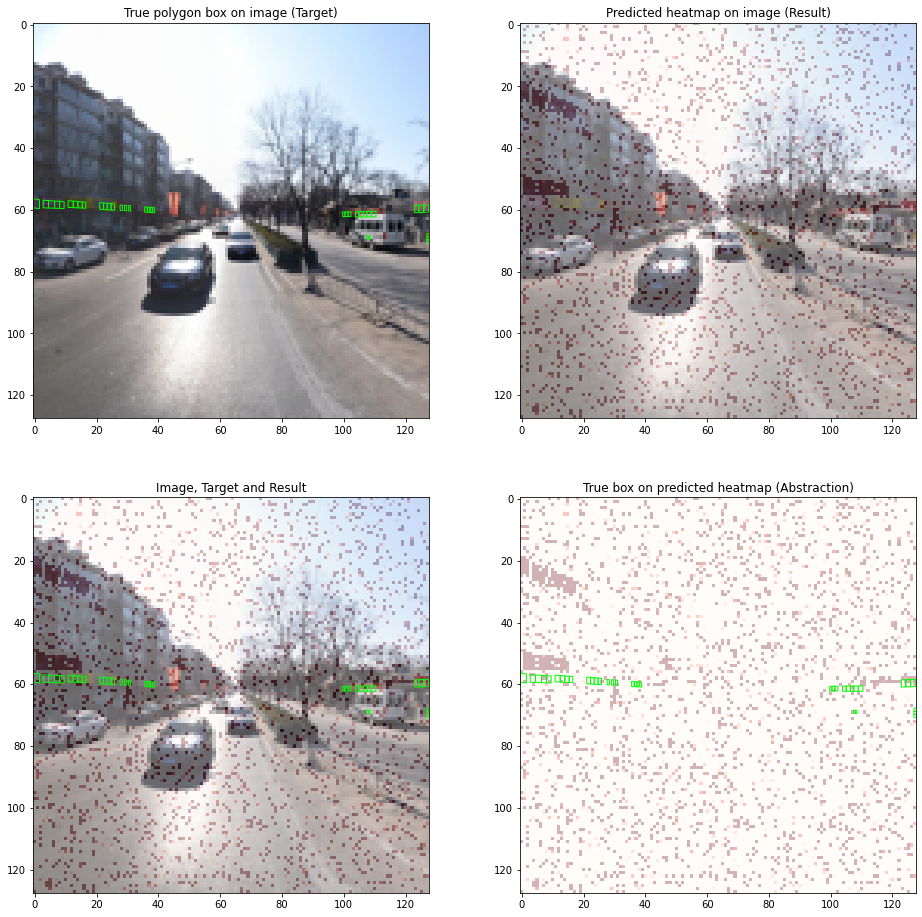

In [35]:
visualize(my_test_file, file2pred_map, mapping)